In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import pandas as pd
np.random.seed(1234)

## Task 1

In [2]:
N_states = 5
P = np.array([
    [0.9915, 0.005,  0.0025, 0,     0.001 ],
    [0,      0.986,  0.005,  0.004, 0.005 ],
    [0,      0,      0.992,  0.003, 0.005 ],
    [0,      0,      0,      0.991, 0.009 ],
    [0,      0,      0,      0,     1     ]
])

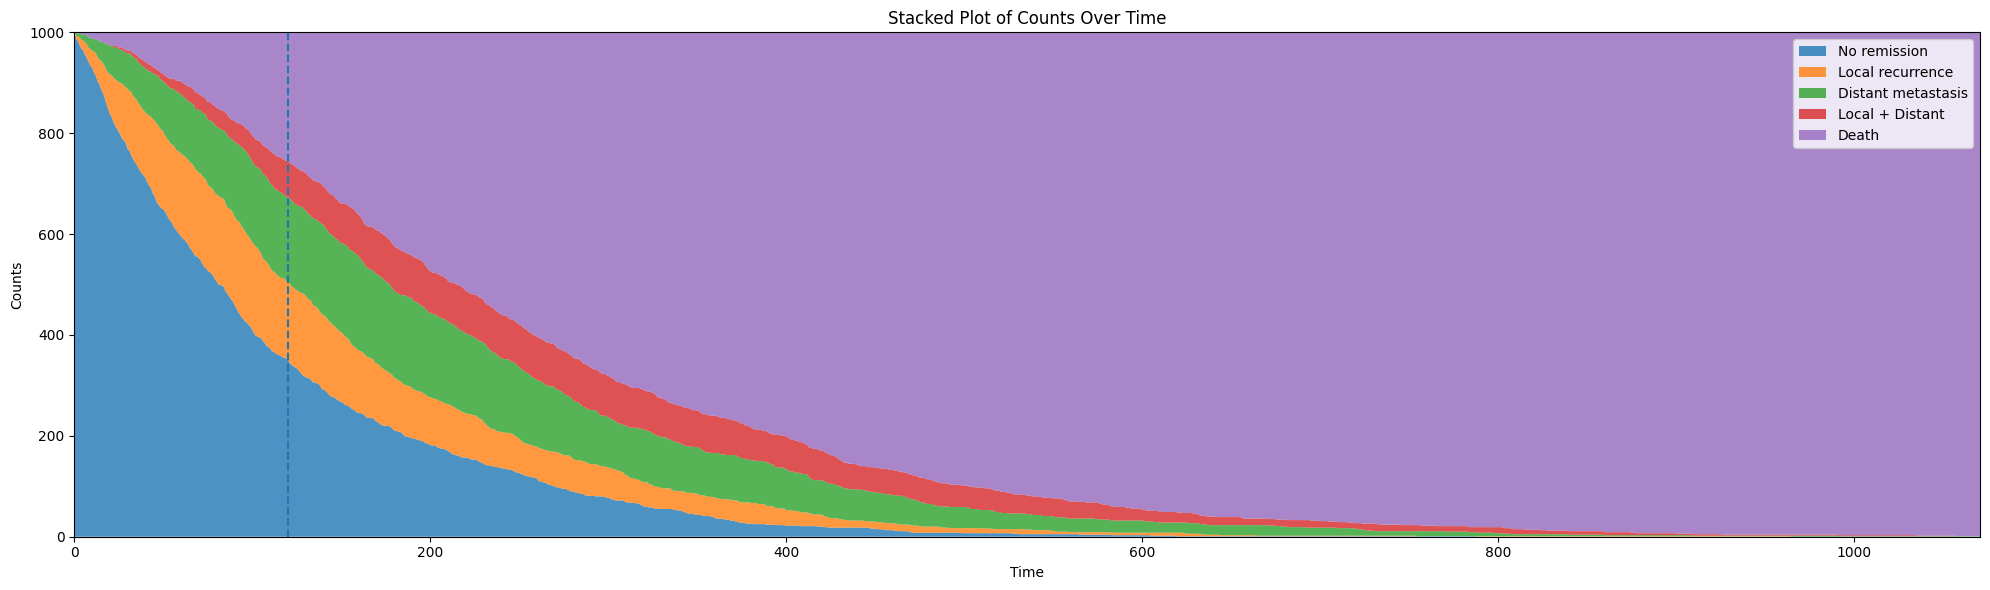

Proportion with local recurrence: 0.703


In [3]:
n_patients = 1000

patients = [0] * n_patients

iterations = [[p for p in patients]]

while not all(p == 4 for p in patients):
    for i, p in enumerate(patients):
        trans_prob = P[p]
        patients[i] = np.random.choice(5, p=trans_prob)
    iterations.append([p for p in patients])

counts = np.zeros((len(iterations), N_states))

for i, it in enumerate(iterations):
    idx, c = np.unique(it, return_counts=True)
    counts[i, idx] = c

x = np.arange(counts.shape[0])
y = counts.T  # shape should be (n_states, n_timesteps)

labels = [
    "No remission",
    "Local recurrence",
    "Distant metastasis",
    "Local + Distant",
    "Death",
]

t = 120

fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.stackplot(x, y, alpha=0.8, labels=labels)
ax.set_xlim(0, counts.shape[0] - 1)
ax.set_ylim(0, n_patients)
ax.set_xlabel("Time")
ax.set_ylabel("Counts")
ax.set_title("Stacked Plot of Counts Over Time")
ax.axvline(t, linestyle="--")
ax.legend(loc="upper right")
fig.tight_layout()
plt.show()

ever_local = sum(
    any(state in (1, 3) for state in patient_traj)
    for patient_traj in zip(*iterations)
)
print(f"Proportion with local recurrence: {ever_local / n_patients:.3f}")

## Task 2

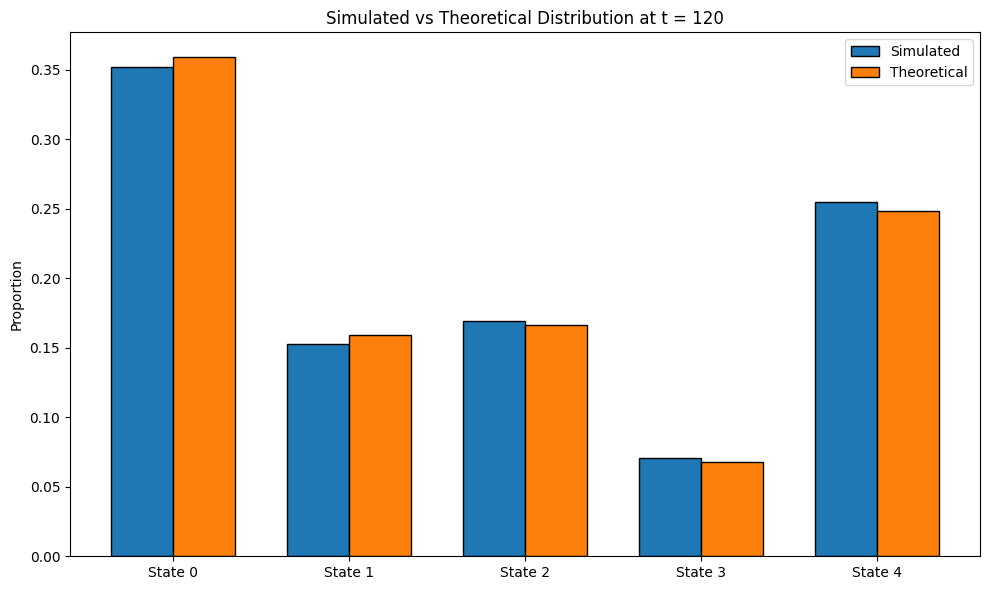

In [4]:
p_simulated = counts[t] / n_patients
p_theoretical = np.array([1, 0, 0, 0, 0]).reshape(1, -1) @ np.linalg.matrix_power(P, t)

plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = np.arange(N_states)

plt.bar(indices - bar_width/2, p_simulated, width=bar_width, label='Simulated', edgecolor='black')
plt.bar(indices + bar_width/2, p_theoretical.flatten(), width=bar_width, label='Theoretical', edgecolor='black')
plt.xticks(indices, ['State 0', 'State 1', 'State 2', 'State 3', 'State 4'])
plt.ylabel('Proportion')
plt.title(f"Simulated vs Theoretical Distribution at t = {t}")
plt.legend()
plt.tight_layout()
plt.show()


## Task 3

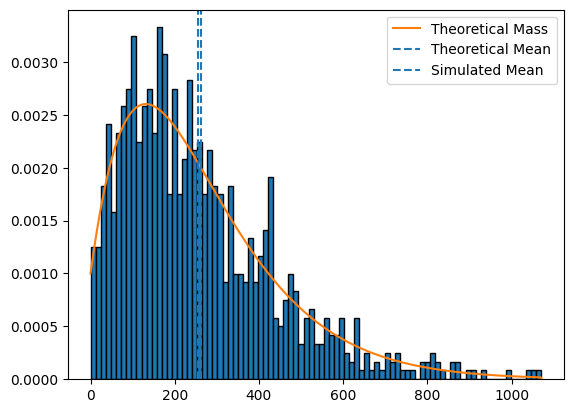

Theoretical mean lifetime: 262.37 months
Simulated mean lifetime:   255.51 months


In [5]:
pi = np.array([1, 0, 0, 0]).reshape(1, -1)
P_s = P[:-1, :-1]
p_s = P[:-1, -1]

lifetimes = []

for i in range(n_patients):
    lifetime = 0 # noone is dead at t=0, given pi
    while True:
        lifetime += 1
        if iterations[lifetime][i] == 4:
            break
    lifetimes.append(lifetime)

lifetimes = np.array(lifetimes)

theoretical_mean = pi @ np.linalg.inv(np.identity(N_states - 1) - P_s) @ np.ones(N_states - 1).reshape(-1, 1)
theoretical_mean = theoretical_mean.item()
simulated_mean = np.mean(lifetimes)

t = np.arange(0, np.max(lifetimes) + 1)
theoretical_mass = np.zeros_like(t).astype(float)

P_s_t = np.identity(N_states - 1)
for i in range(np.max(lifetimes)):
    theoretical_mass[i] = (pi @ P_s_t @ p_s).item()
    P_s_t = P_s_t @ P_s

plt.hist(lifetimes, density=True, bins=np.max(lifetimes) // 12, edgecolor='black')
plt.plot(t, theoretical_mass, label="Theoretical Mass")
plt.gca().axvline(theoretical_mean, linestyle="--", label="Theoretical Mean")
plt.gca().axvline(simulated_mean, linestyle="--", label="Simulated Mean")
plt.legend();
plt.show()
print(f"Theoretical mean lifetime: {theoretical_mean:.2f} months")
print(f"Simulated mean lifetime:   {simulated_mean:.2f} months")

## Task 4

In [6]:
# "early rejection" - only events in the first 12 months dictate wether a sample should be accepted
# therefore, simulate the first 12 months and reject from there, then complete simulation

patients = []
while len(patients) < 1000:
    state = 0
    for _ in range(12):
        state = np.random.choice(5, p=P[state])

    if state not in [0, 4]: # not dead, but has some kind of remission
        patients.append(state)


lifetimes = []
for state in patients:
    lifetime = 12 # we already simulated 12 steps
    while state != 4:
        state = np.random.choice(5, p=P[state])
        lifetime += 1
    lifetimes.append(lifetime)

lifetimes = np.array(lifetimes)

print(f"Mean lifetime (months): {np.mean(lifetimes):.2f}")

Mean lifetime (months): 174.89


## Task 5

In [7]:
# takes ~3 mins to run...
n_iterations = 100
n_patients = 200

lifetimes = np.empty((n_iterations, n_patients))

for i in range(n_iterations):
    for j in range(n_patients):
        lifetime = 0
        state = 0
        while state != 4:
            state = np.random.choice(5, p=P[state])
            lifetime += 1
        lifetimes[i, j] = lifetime

ps = np.mean(lifetimes <= 350, axis=1)
print("Crude estimator:")
print(f"  Mean fraction dead ≤ 350 months: {ps.mean():.4f}")
print(f"  Std of estimator:                {ps.std():.4f}")

mean_lifetimes = np.mean(lifetimes, axis=1)
mean_mean_lifetime = np.mean(mean_lifetimes)

cov = np.cov(ps, mean_lifetimes)

var_p = cov[0, 0]
var_lt = cov[1, 1]
cov_p_lt = cov[0, 1]

# calculate c to minimze variance of estimator based on estimated variances/covariances
c = - cov_p_lt / var_lt

zs = ps + c * (mean_lifetimes - mean_mean_lifetime)

print(f"\nControl variates (c = {c:.5f}):")
print(f"  Mean (adjusted estimator):      {zs.mean():.4f}")
print(f"  Std of adjusted estimator:      {zs.std():.4f}")

Crude estimator:
  Mean fraction dead ≤ 350 months: 0.7409
  Std of estimator:                0.0291

Control variates (c = 0.00190):
  Mean (adjusted estimator):      0.7408
  Std of adjusted estimator:      0.0179
